# Experiment 1
Layers frozen, complete architecture

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import Input, Concatenate
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import numpy as np

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Dataset Acquisition

In [3]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

In [4]:
import tensorflow as tf
from tensorflow.keras import datasets

# Load CIFAR-100 dataset
(x_train_, y_train_), (x_test_, y_test_) = datasets.cifar100.load_data()

# Define the desired image size
target_size = (224, 224)

# Function to preprocess a single image
def preprocess_image(image, label):
    image = tf.image.resize(image, target_size)  # Resize image
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

# Function to process data in batches
def preprocess_in_batches(x_data, y_data, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create preprocessed datasets
batch_size = 64
train_ds = preprocess_in_batches(x_train_, y_train_, batch_size)
test_ds = preprocess_in_batches(x_test_, y_test_, batch_size)

# Check the shape of a single batch
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)


Image batch shape: (64, 224, 224, 3)
Label batch shape: (64, 1)


In [5]:
def generate_blocks(image, block_size=4, num_target_patches=4):
    """
    Generate masked target patches and a context image with patches removed.

    Args:
        image (np.ndarray): Input image as a 2D NumPy array.
        block_size (int): Size of each block.
        num_target_patches (int): Number of target patches to generate.

    Returns:
        tuple: A tuple containing:
            - context (np.ndarray): Image with target patches removed.
            - target_patches (list[np.ndarray]): List of target patches.
    """
    # Ensure image dimensions are divisible by block_size
    image_height, image_width = image.shape[0], image.shape[1]
    assert image_height % block_size == 0, "Image height must be divisible by block_size"
    assert image_width % block_size == 0, "Image width must be divisible by block_size"
    num_rows = image_height // block_size
    num_cols = image_width // block_size

    # Calculate patch indices directly as NumPy arrays
    patch_row_indices = np.arange(0, image_height, block_size)
    patch_col_indices = np.arange(0, image_width, block_size)

    # Initialize context image
    context = image.copy()

    target_patches = []
    target_patch_coords = []
    for _ in range(num_target_patches):
        # Randomly select top-left coordinates for the patch
        top_left_y = np.random.choice(patch_row_indices)
        top_left_x = np.random.choice(patch_col_indices)

        # Randomly determine patch size within bounds
        bottom_right_y = min(
            top_left_y + np.random.choice(np.arange(2 * block_size, 8 * block_size, block_size)),
            image_height
        )
        bottom_right_x = min(
            top_left_x + np.random.choice(np.arange(2 * block_size, 8 * block_size, block_size)),
            image_width
        )

        # Extract the patch directly without copying
        target_patch = np.zeros_like(image)
        target_patch[top_left_y:bottom_right_y, top_left_x:bottom_right_x] = \
            image[top_left_y:bottom_right_y, top_left_x:bottom_right_x]

        # Add the target patch to the list
        target_patches.append(target_patch)

        # Add target patch coords to the list
        target_patch_coords.append((top_left_y, top_left_x, bottom_right_y, bottom_right_x))

        # Remove the patch from the context image
        context[top_left_y:bottom_right_y, top_left_x:bottom_right_x] = 0

    return context, target_patches, target_patch_coords


Target coords:
(8, 20, 32, 32)
(16, 20, 32, 32)
(28, 28, 32, 32)
(24, 24, 32, 32)


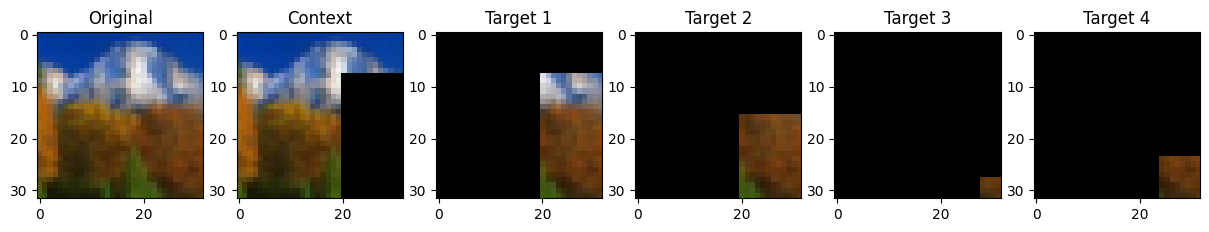

In [6]:
# Example context and target blocks

# choose a random int between 0 and 50000
random_int = np.random.randint(0, 50000)

# Generate blocks
context, target_patches, target_patch_coords = generate_blocks(x_train[random_int])

# Create a figure to show 6 images in a row
fig, axs = plt.subplots(1, 6, figsize=(15, 5))

# Show original in the first column
axs[0].imshow(x_train[random_int])
axs[0].set_title('Original')

# Show context in the second column
axs[1].imshow(context)
axs[1].set_title('Context')

# Show the targets in the rest of the columns
for i in range(2, 6):
    axs[i].imshow(target_patches[i-2])
    axs[i].set_title(f'Target {i-1}')

# Print target coords
print("Target coords:")
for coord in target_patch_coords:
    print(coord)

# Show the plot
plt.show()

# Encoder Decoder

In [7]:
def init_encoder():
    # Load the ResNet50 model without the top classification layers
    encoder = ResNet50(include_top=False, input_shape=(32, 32, 3))

    # Freeze the encoder layers
    for layer in encoder.layers:
        layer.trainable = False

    # Add a global average pooling layer to collapse spatial dimensions
    x = GlobalAveragePooling2D()(encoder.output)

    # Create the new model
    model = Model(inputs=encoder.input, outputs=x)

    return model

# Initialize the encoders
context_encoder = init_encoder()
target_encoder = clone_model(context_encoder)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
context_encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [9]:
target_encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor (InputLayer) │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ keras_tensor[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

# Predictor Model

In [10]:
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model

# Input layers
context_input = Input(shape=(2048,), name='context_input')  # Context encoding for ResNet50
coords_input = Input(shape=(4,), name='coords_input')       # Target patch coordinates

# Concatenate the inputs
x = Concatenate(name='concat_features')([context_input, coords_input])

# Dense layers to process the combined input
x = Dense(2048, activation='relu', name='dense1')(x)  # Adjusted for larger input
x = Dense(1024, activation='relu', name='dense2')(x)  # Reduced size for further processing

# Output layer
output = Dense(512, activation='relu', name='output_vector')(x)  # Final output vector

# Create the model
predictor_model = Model(inputs=[context_input, coords_input], outputs=output, name='predictor_model')

# Model summary
predictor_model.summary()

Model: "predictor_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ context_input             │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ coords_input (InputLayer) │ (None, 4)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_features           │ (None, 2052)           │              0 │ context_input[0][0],   │
│ (Concatenate)             │                        │                │ coords_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1 (Dense)            │ (None, 2048)           │      4,204,544 │ concat_features[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense2 (Dense)            │ (None, 1024)           │      2,098,176 │ dense1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_vector (Dense)     │ (None, 512)            │        524,800 │ dense2[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,827,520 (26.04 MB)

 Trainable params: 6,827,520 (26.04 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Training Parameters
epochs = 10
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_fn = tf.keras.losses.MeanSquaredError()

# EMA Momentum Parameters
initial_momentum = 0.996
final_momentum = 1.0

In [12]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

# Freeze the target encoder
for layer in target_encoder.layers:
    layer.trainable = False

# Build linear probing model
def build_linear_probe_model(encoder, num_classes):
    # Input for image
    input_layer = Input(shape=(32, 32, 3), name="image_input")

    # Pass input through the frozen encoder
    x = encoder(input_layer)

    # Add linear classification head
    output_layer = Dense(num_classes, activation="softmax", name="classification_head")(x)

    # Build model
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Create the linear probing model
num_classes = 100  # CIFAR-100 has 100 classes
linear_probe_model = build_linear_probe_model(target_encoder, num_classes)


In [13]:
# Compile the model
linear_probe_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [14]:
# Load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

# Normalize the images
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Train the linear probing model
history = linear_probe_model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=64,
    epochs=20
)


Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 22ms/step - accuracy: 0.0160 - loss: 4.5801 - val_accuracy: 0.0406 - val_loss: 4.5093
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.0420 - loss: 4.4908 - val_accuracy: 0.0508 - val_loss: 4.4451
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.0530 - loss: 4.4284 - val_accuracy: 0.0620 - val_loss: 4.3960
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.0622 - loss: 4.3774 - val_accuracy: 0.0665 - val_loss: 4.3564
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.0697 - loss: 4.3377 - val_accuracy: 0.0668 - val_loss: 4.3199
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.0745 - loss: 4.3045 - val_accuracy: 0.0738 - val_loss: 4.2904
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.0775 - loss: 4.2729 - val_accuracy: 0.0785 - val_loss: 4.2636
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.0786 - loss: 4.2496 - val_ac

In [15]:
# Evaluate on the test set
test_loss, test_accuracy = linear_probe_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.1099 - loss: 4.0542
Test Accuracy: 11.04%
